In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
import numpy as np
import scipy.stats as ss
import pandas as pd
import itertools
from os import path
import pickle
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 13]
pd.options.display.width = 500
n_bins_default = 15

In [3]:
def load_cache(file_path):
    with open(path.expanduser(file_path), 'rb') as f:
        cache_dict = pickle.load(f)
        df = cache_dict['df']
        p = list(cache_dict['parameter_names'])
        return df, p

In [4]:
class ModelPlot:
    def __init__(self, x, y, d, label, color, linewidth=3, linestyle=None):
        self.label = label
        self.color = color
        self.linewidth = linewidth
        self.linestyle = linestyle
        self.x = x
        self.y = y
        self.d = d

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

def plot_model(model_plot_list, n_bins, ax=None, percentiles=None):
    p = ax if ax is not None else plt
    for model_plot in model_plot_list:
        d_grouped_by_gs = model_plot.d.groupby(pd.cut(model_plot.d[model_plot.x.name], n_bins))
        d_grouped_by_gs_agg = d_grouped_by_gs.agg([np.mean, percentile(25), percentile(75), percentile(95)])
        
        p.plot(
            d_grouped_by_gs_agg[model_plot.x.name]['mean'],
            d_grouped_by_gs_agg[model_plot.y.name]['mean'],
            label=model_plot.label,
            color=model_plot.color,
            linewidth=model_plot.linewidth,
            linestyle=model_plot.linestyle,
        )
        if percentiles and 25 in percentiles:
            p.plot(
                d_grouped_by_gs_agg[model_plot.x.name]['mean'],
                d_grouped_by_gs_agg[model_plot.y.name]['percentile_25'],
                label=model_plot.label + ' percentile_25',
                color=model_plot.color,
                linestyle=':',
                linewidth=model_plot.linewidth/2,
            )
        if percentiles and 75 in percentiles:
            p.plot(
                d_grouped_by_gs_agg[model_plot.x.name]['mean'],
                d_grouped_by_gs_agg[model_plot.y.name]['percentile_75'],
                label=model_plot.label + ' percentile_75',
                color=model_plot.color,
                linestyle='-.',
                linewidth=model_plot.linewidth/2,
            )
        if percentiles and 95 in percentiles:
            p.plot(
                d_grouped_by_gs_agg[model_plot.x.name]['mean'],
                d_grouped_by_gs_agg[model_plot.y.name]['percentile_95'],
                label=model_plot.label + ' percentile_95',
                color=model_plot.color,
                linestyle='--',
                linewidth=model_plot.linewidth/2,
            )
        
        if ax is not None:
            ax.set(xlabel=model_plot.x.name, ylabel=model_plot.y.name)
        else:
            plt.xlabel(model_plot.x.name)
            plt.ylabel(model_plot.y.name)

In [5]:
rename_dict = {
    'relative_localization_error_translation_mean': 'translation_error',
    'geometric_similarity_sensor_mean_of_translation_eigenvalues_ratio_all': 'tgs',
    'lidar_visibility_mean_visible_ranges_ratio': 'lvr',
    'waypoint_start_time': 'start_time',
}
p = [
    'laser_scan_max_range',
    'laser_scan_fov_deg',
    'beta',
    'environment_name',
    'linear_update',
    'slam_node',
]
m = [
    'start_time',
    'translation_error',
    'tgs',
    'lvr',
]
df, params = load_cache("/home/enrico/ds/performance_modelling/output/slam_new_config/run_data_per_waypoint_cache.pkl")
df.rename(columns=rename_dict, inplace=True)
df['linear_update'] = df['linear_angular_update'].apply(lambda x: x[0])
df = df[p+m]

for c in p:
    print("{:>30}".format(c), sorted(list(df[c].unique())))

          laser_scan_max_range [3.5, 8.0, 30.0]
            laser_scan_fov_deg [90, 180, 359]
                          beta [(0.0, 0.0, 0.0, 0.0), (2.0, 0.0, 2.0, 0.0)]
              environment_name ['7A-2', 'airlab', 'fr079', 'office_b']
                 linear_update [0.2, 0.5]
                     slam_node ['gmapping', 'slam_toolbox']


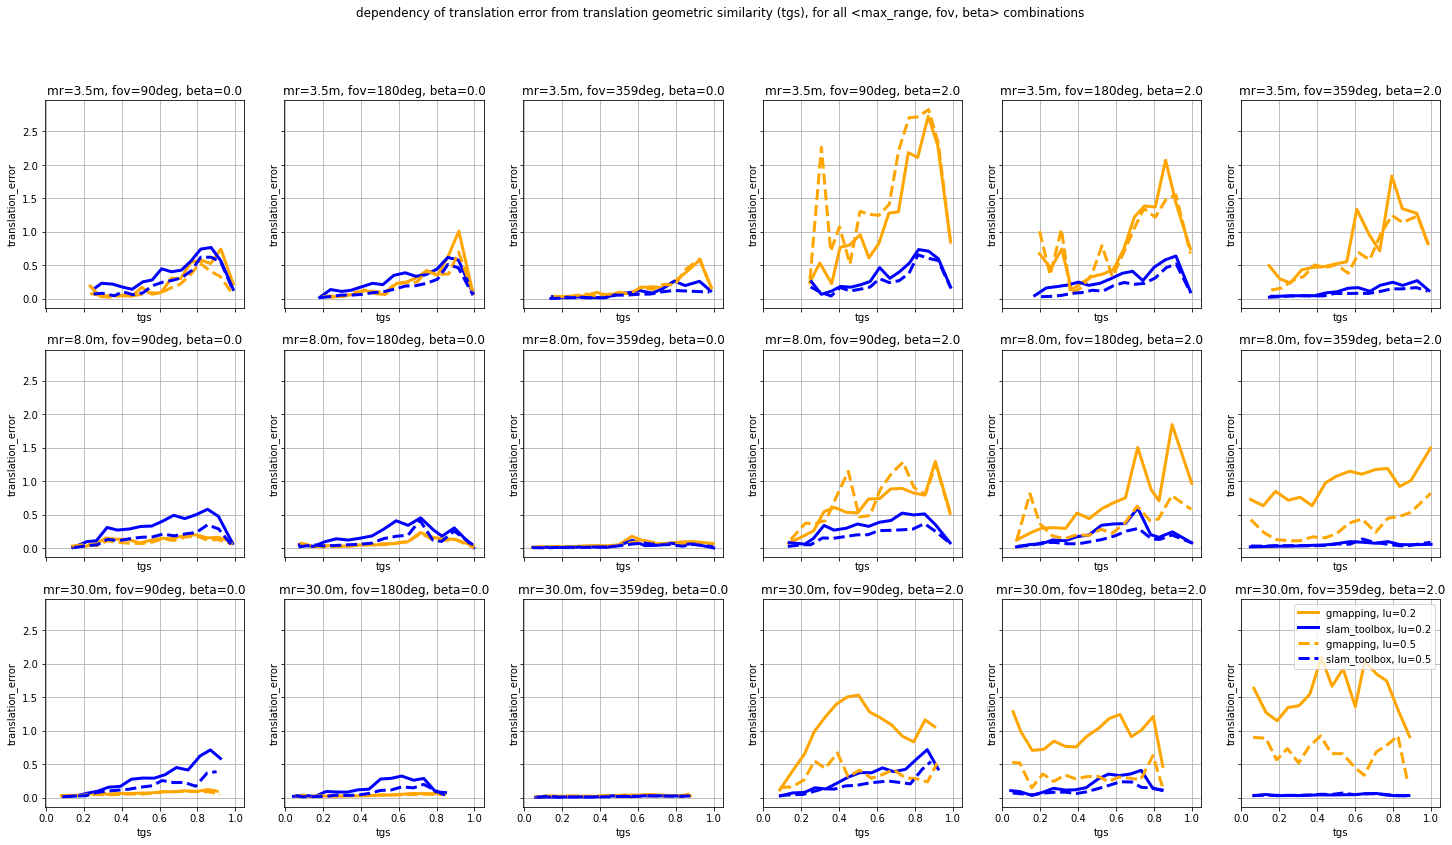

In [19]:
mrs = sorted(list(df.laser_scan_max_range.unique()))
fovs = sorted(list(df.laser_scan_fov_deg.unique()))
betas = sorted(list(df.beta.unique()))
lus = sorted(list(df.linear_update.unique()))

betas_fovs = list(itertools.product(betas, fovs))

fig, axs = plt.subplots(len(mrs), len(betas_fovs))
for ax in axs.flat:
    ax.set(xlabel='translation geometric similarity (fixed range and fov)', ylabel='translation error')
for ax in axs.flat:
    ax.label_outer()
for i, mr in enumerate(mrs):
    for j, (beta, fov) in enumerate(betas_fovs):
        plot_model(
            [
                ModelPlot(
                    df.tgs,
                    df.translation_error,
                    df[(df.slam_node == 'gmapping') &
                       (df.laser_scan_max_range == mr) &
                       (df.linear_update == lus[0]) &
                       (df.laser_scan_fov_deg == fov) &
                       (df.beta == beta)],
                    f'gmapping, lu={lus[0]}', 'orange', linestyle='-'),
                ModelPlot(
                    df.tgs,
                    df.translation_error,
                    df[(df.slam_node == 'slam_toolbox') &
                       (df.linear_update == lus[0]) &
                       (df.laser_scan_max_range == mr) &
                       (df.laser_scan_fov_deg == fov) &
                       (df.beta == beta)],
                    f'slam_toolbox, lu={lus[0]}', 'blue', linestyle='-'),
                ModelPlot(
                    df.tgs,
                    df.translation_error,
                    df[(df.slam_node == 'gmapping') &
                       (df.linear_update == lus[1]) &
                       (df.laser_scan_max_range == mr) &
                       (df.laser_scan_fov_deg == fov) &
                       (df.beta == beta)],
                    f'gmapping, lu={lus[1]}', 'orange', linestyle='--'),
                ModelPlot(
                    df.tgs,
                    df.translation_error,
                    df[(df.slam_node == 'slam_toolbox') &
                       (df.linear_update == lus[1]) &
                       (df.laser_scan_max_range == mr) &
                       (df.laser_scan_fov_deg == fov) &
                       (df.beta == beta)],
                    f'slam_toolbox, lu={lus[1]}', 'blue', linestyle='--'),
            ], 
            n_bins_default,
            axs[i, j],
#             percentiles=[25, 75],
        )
        axs[i, j].set_title(f"mr={mr}m, fov={fov}deg, beta={max(beta)}")
        axs[i, j].sharex(axs[0, 0])
        axs[i, j].sharey(axs[0, 0])
        axs[i, j].grid(True)

plt.legend()
plt.suptitle("dependency of translation error from translation geometric similarity (tgs), for all <max_range, fov, beta> combinations")
plt.show()

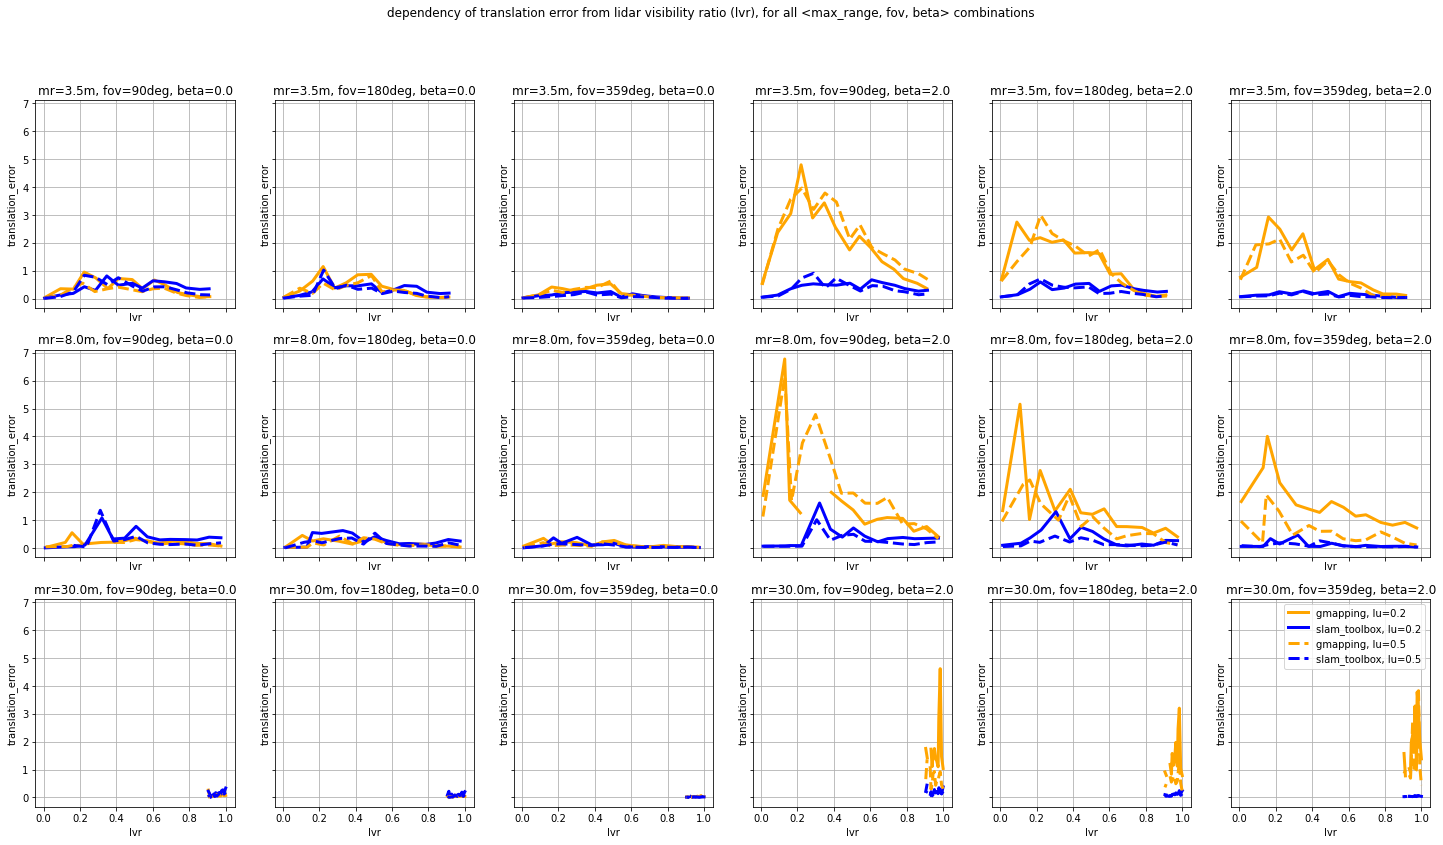

In [18]:
mrs = sorted(list(df.laser_scan_max_range.unique()))
fovs = sorted(list(df.laser_scan_fov_deg.unique()))
betas = sorted(list(df.beta.unique()))
lus = sorted(list(df.linear_update.unique()))

betas_fovs = list(itertools.product(betas, fovs))

fig, axs = plt.subplots(len(mrs), len(betas_fovs))
for ax in axs.flat:
    ax.set(xlabel='translation geometric similarity (fixed range and fov)', ylabel='translation error')
for ax in axs.flat:
    ax.label_outer()
for i, mr in enumerate(mrs):
    for j, (beta, fov) in enumerate(betas_fovs):
        plot_model(
            [
                ModelPlot(
                    df.lvr,
                    df.translation_error,
                    df[(df.slam_node == 'gmapping') &
                       (df.laser_scan_max_range == mr) &
                       (df.linear_update == lus[0]) &
                       (df.laser_scan_fov_deg == fov) &
                       (df.beta == beta)],
                    f'gmapping, lu={lus[0]}', 'orange', linestyle='-'),
                ModelPlot(
                    df.lvr,
                    df.translation_error,
                    df[(df.slam_node == 'slam_toolbox') &
                       (df.linear_update == lus[0]) &
                       (df.laser_scan_max_range == mr) &
                       (df.laser_scan_fov_deg == fov) &
                       (df.beta == beta)],
                    f'slam_toolbox, lu={lus[0]}', 'blue', linestyle='-'),
                ModelPlot(
                    df.lvr,
                    df.translation_error,
                    df[(df.slam_node == 'gmapping') &
                       (df.linear_update == lus[1]) &
                       (df.laser_scan_max_range == mr) &
                       (df.laser_scan_fov_deg == fov) &
                       (df.beta == beta)],
                    f'gmapping, lu={lus[1]}', 'orange', linestyle='--'),
                ModelPlot(
                    df.lvr,
                    df.translation_error,
                    df[(df.slam_node == 'slam_toolbox') &
                       (df.linear_update == lus[1]) &
                       (df.laser_scan_max_range == mr) &
                       (df.laser_scan_fov_deg == fov) &
                       (df.beta == beta)],
                    f'slam_toolbox, lu={lus[1]}', 'blue', linestyle='--'),
            ], 
            n_bins_default,
            axs[i, j],
#             percentiles=[25, 75],
        )
        axs[i, j].set_title(f"mr={mr}m, fov={fov}deg, beta={max(beta)}")
        axs[i, j].sharex(axs[0, 0])
        axs[i, j].sharey(axs[0, 0])
        axs[i, j].grid(True)

plt.legend()
plt.suptitle("dependency of translation error from lidar visibility ratio (lvr), for all <max_range, fov, beta> combinations")
plt.show()

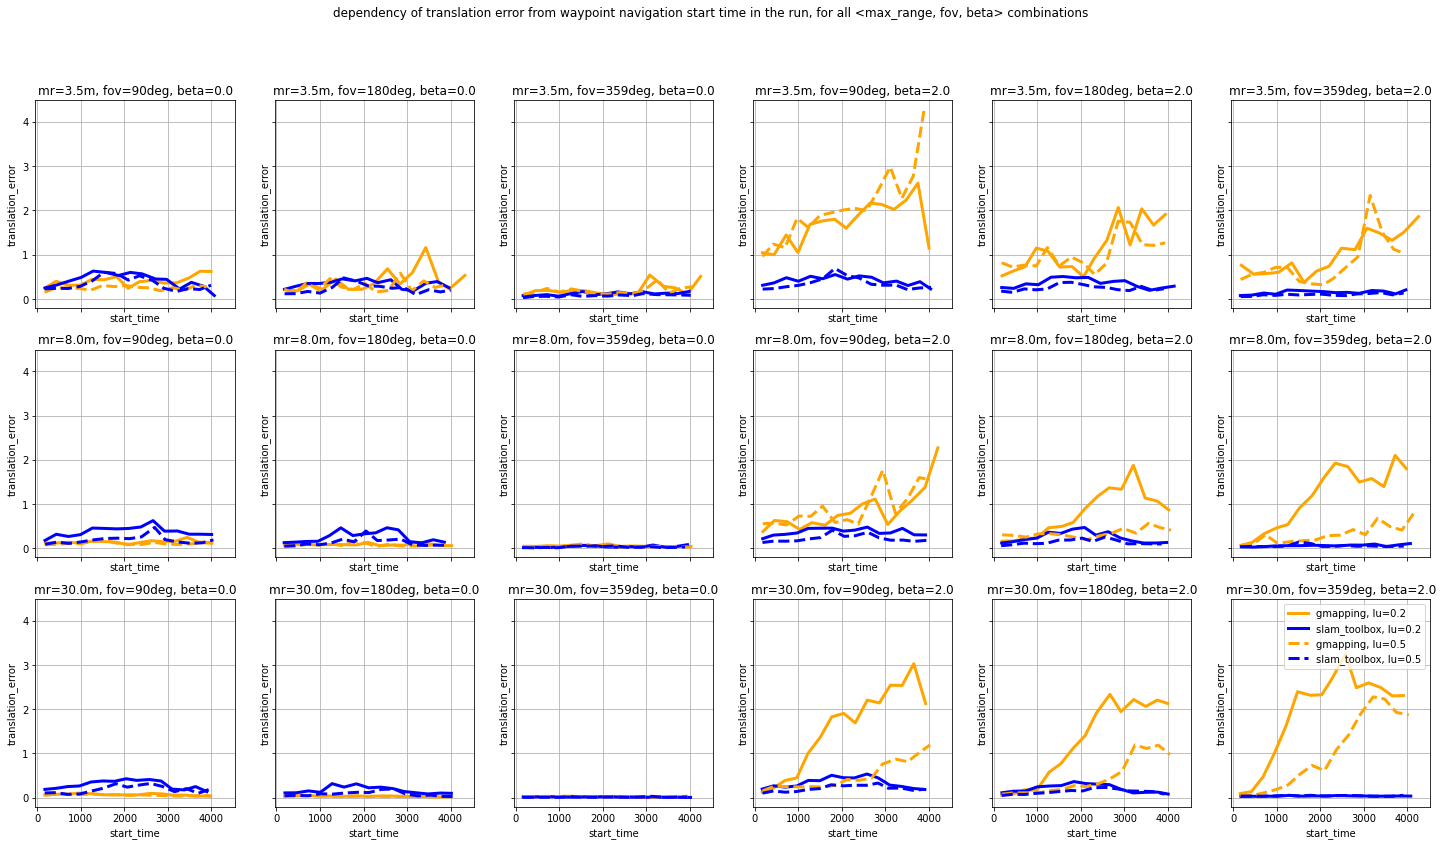

In [12]:
mrs = sorted(list(df.laser_scan_max_range.unique()))
fovs = sorted(list(df.laser_scan_fov_deg.unique()))
betas = sorted(list(df.beta.unique()))
lus = sorted(list(df.linear_update.unique()))

betas_fovs = list(itertools.product(betas, fovs))

fig, axs = plt.subplots(len(mrs), len(betas_fovs))
for ax in axs.flat:
    ax.set(xlabel='translation geometric similarity (fixed range and fov)', ylabel='translation error')
for ax in axs.flat:
    ax.label_outer()
for i, mr in enumerate(mrs):
    for j, (beta, fov) in enumerate(betas_fovs):
        plot_model(
            [
                ModelPlot(
                    df.start_time,
                    df.translation_error,
                    df[(df.slam_node == 'gmapping') &
                       (df.laser_scan_max_range == mr) &
                       (df.linear_update == lus[0]) &
                       (df.laser_scan_fov_deg == fov) &
                       (df.beta == beta)],
                    f'gmapping, lu={lus[0]}', 'orange', linestyle='-'),
                ModelPlot(
                    df.start_time,
                    df.translation_error,
                    df[(df.slam_node == 'slam_toolbox') &
                       (df.linear_update == lus[0]) &
                       (df.laser_scan_max_range == mr) &
                       (df.laser_scan_fov_deg == fov) &
                       (df.beta == beta)],
                    f'slam_toolbox, lu={lus[0]}', 'blue', linestyle='-'),
                ModelPlot(
                    df.start_time,
                    df.translation_error,
                    df[(df.slam_node == 'gmapping') &
                       (df.linear_update == lus[1]) &
                       (df.laser_scan_max_range == mr) &
                       (df.laser_scan_fov_deg == fov) &
                       (df.beta == beta)],
                    f'gmapping, lu={lus[1]}', 'orange', linestyle='--'),
                ModelPlot(
                    df.start_time,
                    df.translation_error,
                    df[(df.slam_node == 'slam_toolbox') &
                       (df.linear_update == lus[1]) &
                       (df.laser_scan_max_range == mr) &
                       (df.laser_scan_fov_deg == fov) &
                       (df.beta == beta)],
                    f'slam_toolbox, lu={lus[1]}', 'blue', linestyle='--'),
            ], 
            n_bins_default,
            axs[i, j],
#             percentiles=[25, 75],
        )
        axs[i, j].set_title(f"mr={mr}m, fov={fov}deg, beta={max(beta)}")
        axs[i, j].sharex(axs[0, 0])
        axs[i, j].sharey(axs[0, 0])
        axs[i, j].grid(True)

plt.legend()
plt.suptitle("dependency of translation error from waypoint navigation start time in the run, for all <max_range, fov, beta> combinations")
plt.show()

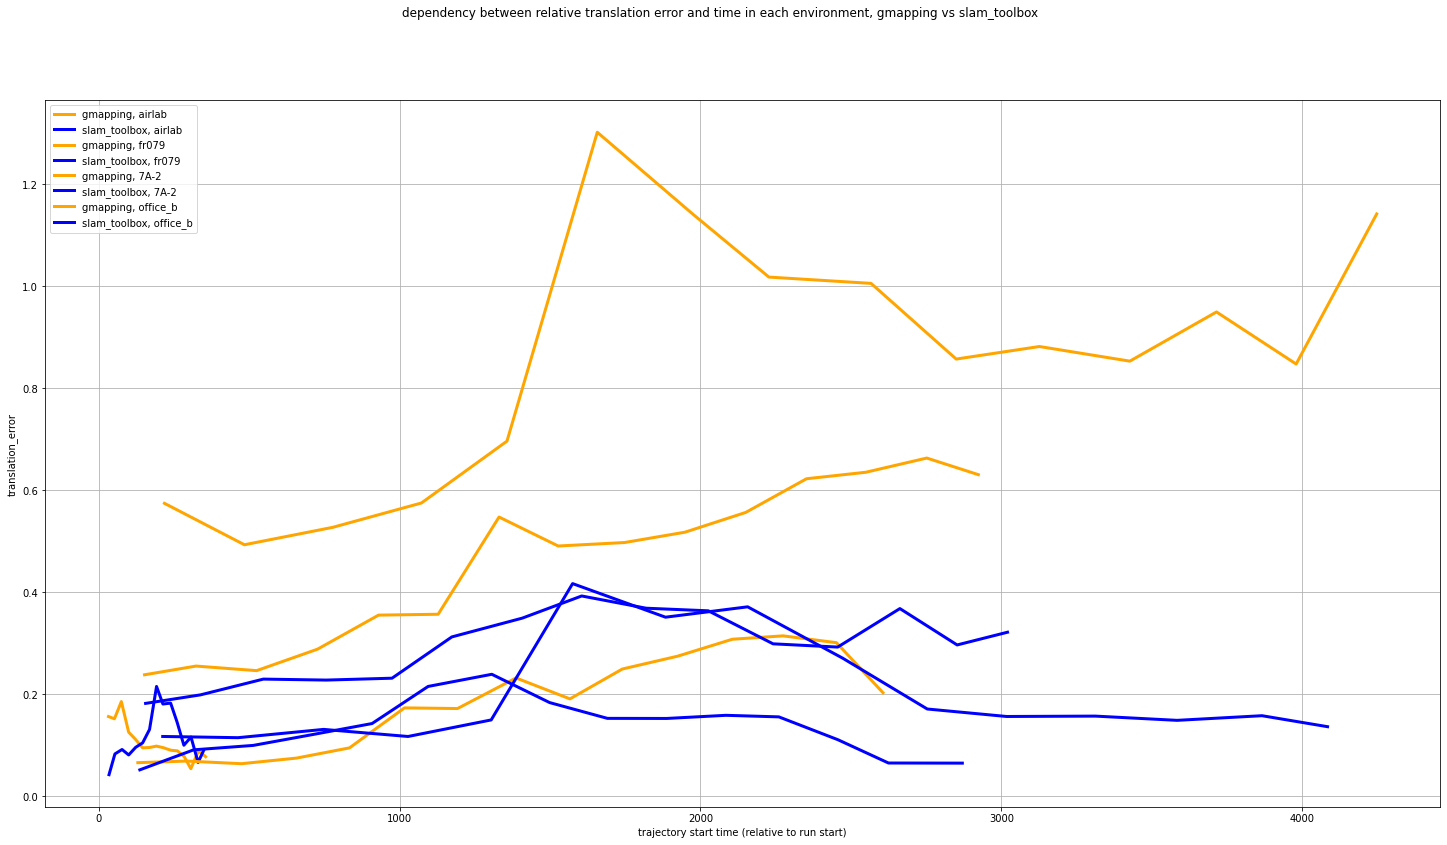

In [13]:
for env in df.environment_name.unique():
    df_env = df[df.environment_name.isin([env])]
    plot_model(
        [
            ModelPlot(
                df_env.start_time, 
                df_env.translation_error, 
                df_env[df_env.slam_node == 'gmapping'], 
                f'gmapping, {env}', 'orange'), 
            ModelPlot(
                df_env.start_time,
                df_env.translation_error, 
                df_env[df_env.slam_node == 'slam_toolbox'], 
                f'slam_toolbox, {env}', 'blue'),
        ],
        n_bins_default)

plt.legend()
plt.xlabel("trajectory start time (relative to run start)")
plt.grid(True)
plt.suptitle("dependency between relative translation error and time in each environment, gmapping vs slam_toolbox")
plt.show()

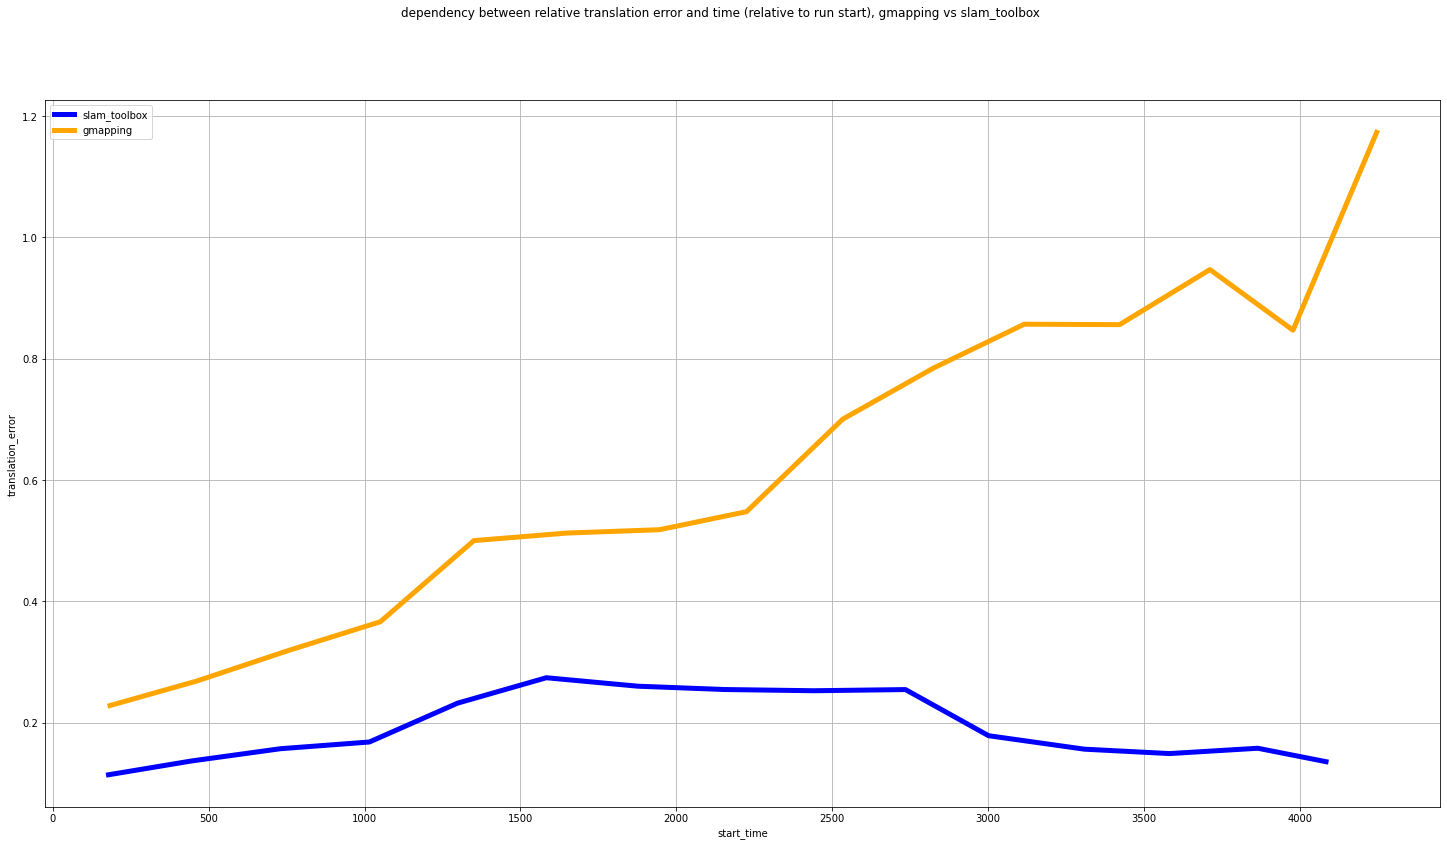

In [14]:
plot_model(
    [
        ModelPlot(
            df.start_time,
            df.translation_error, 
            df[df.slam_node == 'slam_toolbox'], 
            'slam_toolbox', 'blue', linewidth=5),
        ModelPlot(
            df.start_time, 
            df.translation_error, 
            df[df.slam_node == 'gmapping'], 
            'gmapping', 'orange', linewidth=5), 
    ],
    n_bins_default,
#     percentiles=[25, 95],
)

plt.legend()
plt.grid(True)
plt.suptitle("dependency between relative translation error and time (relative to run start), gmapping vs slam_toolbox")
plt.show()

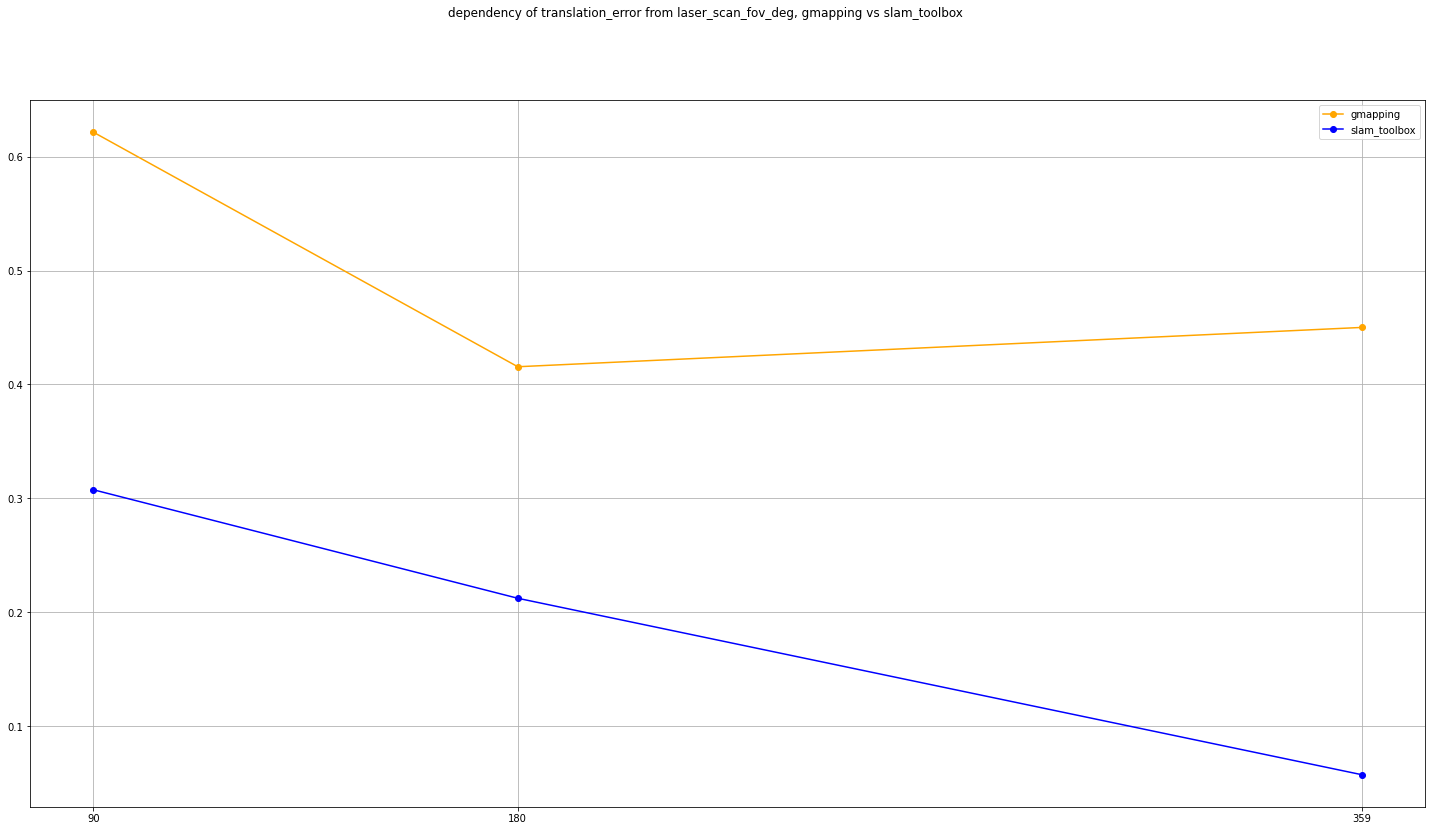

In [15]:
param = df.laser_scan_fov_deg
performance_metric = df.translation_error

df_param = df.groupby([df.slam_node, param]).mean()
df_gm_param = df_param.loc['gmapping']
plt.plot(df_gm_param.index, df_gm_param[performance_metric.name], label='gmapping', color='orange', marker='o')
df_st_param = df_param.loc['slam_toolbox']
plt.plot(df_st_param.index, df_st_param[performance_metric.name], label='slam_toolbox', color='blue', marker='o')

plt.xticks(param.unique())
plt.legend()
plt.grid()
plt.suptitle(f"dependency of {performance_metric.name} from {param.name}, gmapping vs slam_toolbox")
plt.show()

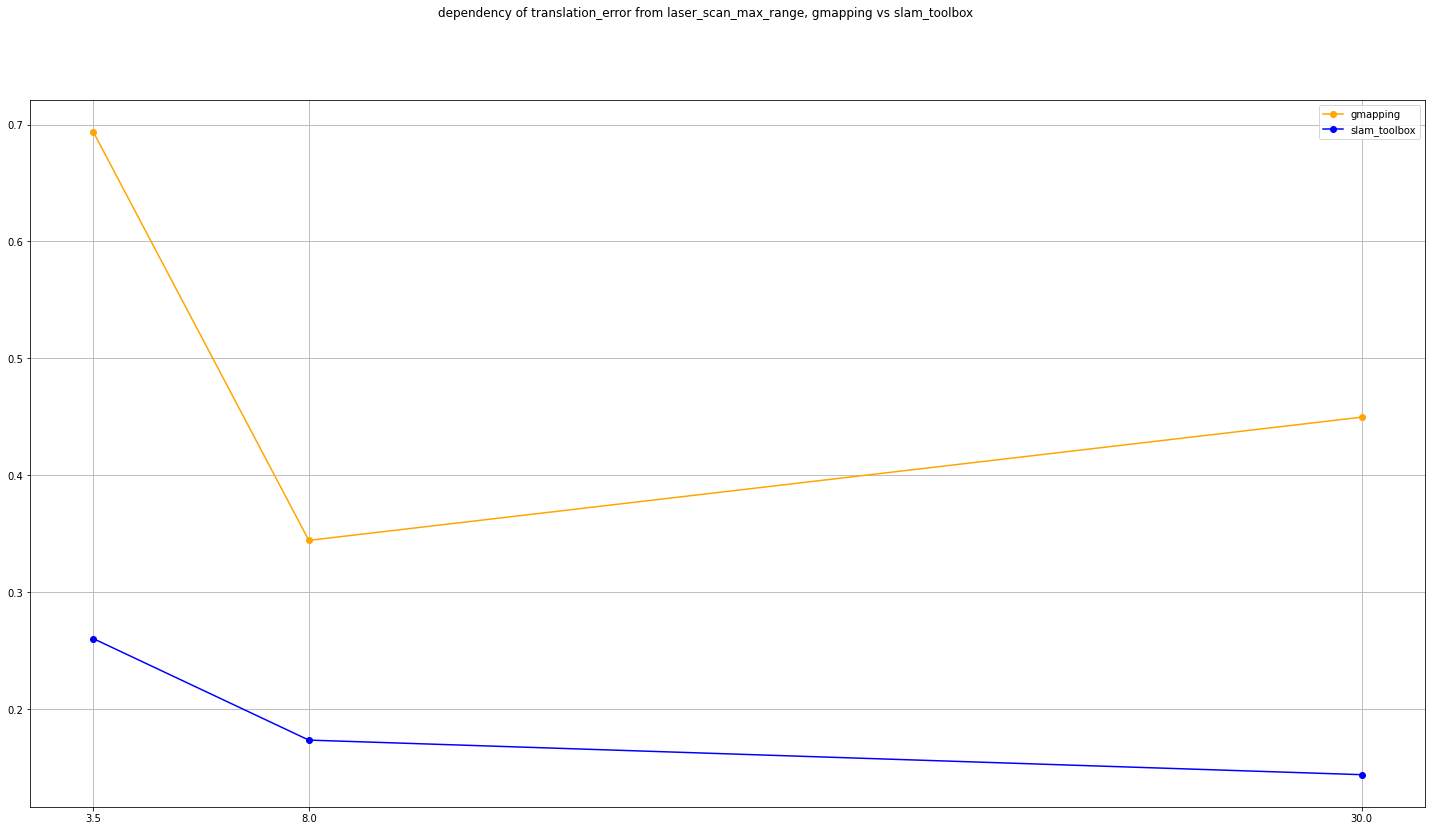

In [16]:
param = df.laser_scan_max_range
performance_metric = df.translation_error

df_param = df.groupby([df.slam_node, param]).mean()
df_gm_param = df_param.loc['gmapping']
plt.plot(df_gm_param.index, df_gm_param[performance_metric.name], label='gmapping', color='orange', marker='o')
df_st_param = df_param.loc['slam_toolbox']
plt.plot(df_st_param.index, df_st_param[performance_metric.name], label='slam_toolbox', color='blue', marker='o')

plt.xticks(param.unique())
plt.legend()
plt.grid()
plt.suptitle(f"dependency of {performance_metric.name} from {param.name}, gmapping vs slam_toolbox")
plt.show()

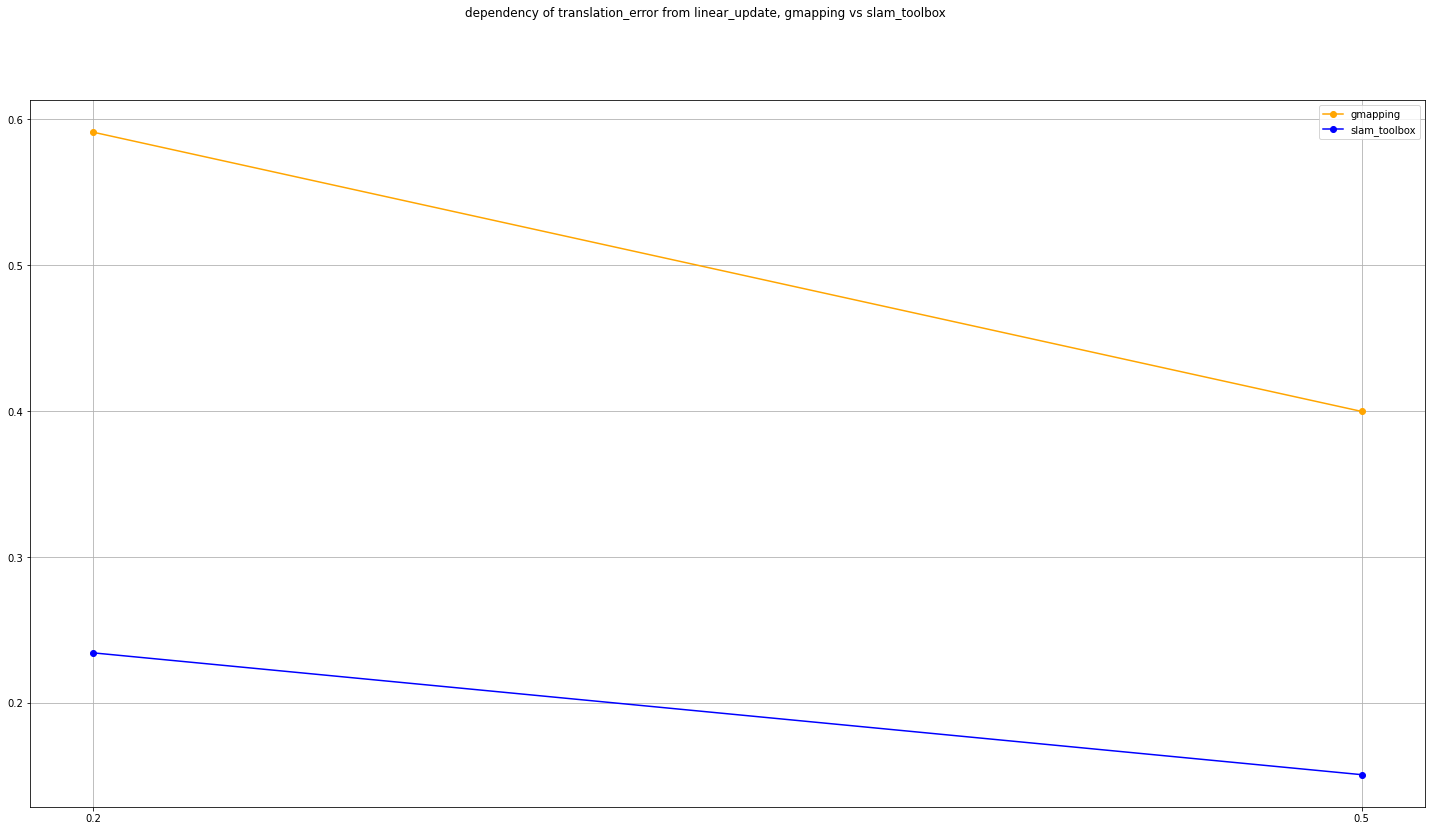

In [17]:
param = df.linear_update
performance_metric = df.translation_error

df_param = df.groupby([df.slam_node, param]).mean()
df_gm_param = df_param.loc['gmapping']
plt.plot(df_gm_param.index, df_gm_param[performance_metric.name], label='gmapping', color='orange', marker='o')
df_st_param = df_param.loc['slam_toolbox']
plt.plot(df_st_param.index, df_st_param[performance_metric.name], label='slam_toolbox', color='blue', marker='o')

plt.xticks(param.unique())
plt.legend()
plt.grid()
plt.suptitle(f"dependency of {performance_metric.name} from {param.name}, gmapping vs slam_toolbox")
plt.show()